### Reinforcement Learning ##################
### Rihab Alzurkani   268102



## Deep Q-Learning and Variants in Gym's AIR Raid Module

In this notebook, we will explore the implementation of a Deep Q-Learning (DQN) agent to navigate  AIR Raid environment. 

We will use apply four variants of the DQN algorithm:
- The Classic DQN (Mihn et al 2013)
- Double DQN (Hasselt et al 2015)
- Dueling DQN (Wang et al 2015)
- Double Dueling DQN



All reinforcement learning (RL) methods will be built from scratch, providing a comprehensive understanding of their workings and we will use PyTorch to build our neural network model.



In [1]:
# To use in Kaggle we need to install these two packages
!pip install swig 
!pip install gym[box2d]

### 1.1 Atari gym environments
#### Install and import relevant libraries

In [2]:
!pip install gymnasium[atari]
!pip install autorom



In [3]:
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]


In [1]:
import gym

env = gym.make('ALE/AirRaid-ram-v5')
env.reset(seed=42)

# Play one complete episode with random actions
while True:
    action = env.action_space.sample() 
    _, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    
env.close()

In [2]:
import gymnasium as gym
import numpy as np
import torch
from torch import nn
from torch.functional import F
from torch import optim
import random
from matplotlib import pyplot as plt

RANDOM_STATE = 1234
ENV_NAME = ('ALE/AirRaid-ram-v5')
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [3]:
env = gym.make('ALE/AirRaid-ram-v5')
#state = env.observation_space.shape()
states = env.observation_space.shape[0]
actions = env.action_space.n

#### Explore environment

In [4]:
# Ensure that environment exists
assert ENV_NAME in gym.envs.registry.keys()

# Create an instance of enviroment
env = gym.make(ENV_NAME, obs_type='rgb')

# Verify essential properties of the environment
state = env.reset()[0]
print("Initial state dimension: {}".format(state.shape))
print("Observation space:".format(env.observation_space))
print(f"Action space: {env.action_space}")
a = env.action_space.sample()
event = env.step(a)
next_state = event[0]
print("\nOutput from applying action {} on environment:\n(state dimension:".format(a) \
      + "{}\nreward: {}\nterminated: {}\ntruncated: {}\ninfo: {})".format(next_state.shape,*event[1:]))

Initial state dimension: (250, 160, 3)
Observation space:
Action space: Discrete(6)

Output from applying action 5 on environment:
(state dimension:(250, 160, 3)
reward: 0.0
terminated: False
truncated: False
info: {'lives': 1, 'episode_frame_number': 12, 'frame_number': 20})


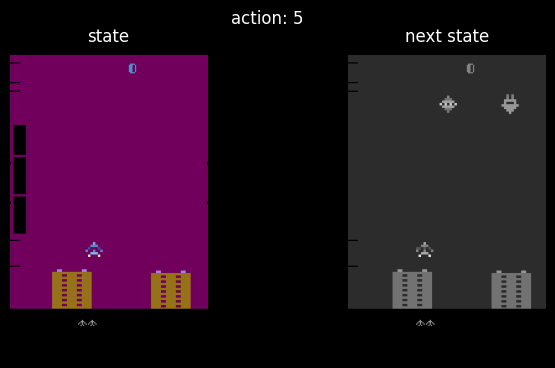

In [5]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)
ax.imshow(state)
ax.axis('off')
ax.set_title('state')
ax = fig.add_subplot(122)
ax.imshow(event[0])
ax.axis('off')
ax.set_title('next state')
plt.suptitle(f'action: {a}')
plt.show()

just an informational message that confirms ALE is running correctly.



## General Information
This environment is part of the Atari environments. Please read that page first for general information



| Feature Category  | Details                                |
|-------------------|----------------------------------------|
| Action Space      | Discrete(6)                            |
| Observation Space | (Box(0, 255, (250, 160, 3), uint8))                                   |

| Import            | `gym.make("AIR Raid-ram-v5")`           |

## Description of Environment

In this environoment we need to control a ship that can move sideways. You must protect two buildings (one on the right and one on the left side of the screen from flying saucers that are trying to drop bombs on them.

## Action Space
Actions
AirRaid has the action space of Discrete(6) with the table below listing the meaning of each action’s meanings. To enable all 18 possible actions that can be performed on an Atari 2600, specify full_action_space=True during initialization or by passing full_action_space=True to gymnasium.make.

| Action  | Result                          |
|---------|---------------------------------|
| 0       | NOOP                            |
| 1       | FIRE                            |
| 2       | RIGHT                           |
| 3       | LEFT                            |
| 4       | RIGHT FIRE                      |
| 5       | LEFT FIRE                       |

## Observation Space
Atari environments have three possible observation types: "rgb", "grayscale" and "ram".

obs_type="rgb" -> observation_space=Box(0, 255, (210, 160, 3), np.uint8)

obs_type="ram" -> observation_space=Box(0, 255, (128,), np.uint8)

obs_type="grayscale" -> Box(0, 255, (210, 160), np.uint8), a grayscale version of the “rgb” type



## Version History
A thorough discussion of the intricate differences between the versions and configurations can be found in the general article on Atari environments.

## v5: 
Stickiness was added back and stochastic frame-skipping was removed. The environments are now in the “ALE” namespace.

## v4: 
Stickiness of actions was removed

## v0: 
Initial versions release



## Starting State
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

## Episode Termination
Use actual game over In most of the Atari games the player has multiple
lives and the game is actually over when all lives are lost. But some articles, e.g. DQN, Rainbow,
IQN, end a training episode after the loss of the first life but still use the standard game over signal
while testing. This can in fact help the agent to learn how to avoid death and is an unfair comparison
to agents which are not using this game-specific (Marlos C Machado, Marc G Bellemare, Erik Talvitie, Joel Veness, Matthew Hausknecht, and Michael
Bowling. Revisiting the arcade learning environment: Evaluation protocols and open problems for general
agents. Journal of Artificial Intelligence Research, 61:523–562, 2018).


## The Safe Agent
We're going to implement a simple agent 'The Safe Agent' who will thrust upward if and only if the lander's `y` position is less than 0.5.

In theory this agent shouldn't hit the ground as we have unlimited fuel, but let's see.

In [6]:
class SafeAgent:
    '''
    An agent that will simply fly upward if the lander gets too close to the ground.
    '''
    def act(self, state):
        '''
        Decision making method. 
        Fly up if below the minimum height.
        '''
        MIN_HEIGHT = 1

        if state[1] < MIN_HEIGHT:
            return 2
        else:
            return 0


def play_episode(env, agent, seed=42):
    '''
    Plays a full episode for a given agent, environment and seed.
    '''
    score = 0
    state, _ = env.reset(seed=seed)
    
    while True:
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated

        score += reward

        # End the episode if done
        if done:
            break 


env = gym.make('ALE/AirRaid-ram-v5')
agent = SafeAgent()

play_episode(env, agent)

In [7]:
class StableAgent:
    '''
    An agent that attempts to fly the lander stably using a set of inflexible rules.
    '''
    def act(self, state):
        '''
        Decision making method.
        Fly according to the rules described above.
        '''
        # Decision making thresholds
        UPPER_MIN_Y = 1.5
        LOWER_MIN_Y = 1
        MIN_X = -0.4
        MAX_X = 0.4
        MIN_ANGLE = -3.14/50
        MAX_ANGLE = 3.14/50

        # Convenient forms for angle, x and y coordinates
        x = state[0]
        y = state[1]
        angle = state[4]

        # Avoiding magic numbers for readability
        MAIN_ENGINE = 2
        LEFT_ENGINE = 1
        RIGHT_ENGINE = 3
        DO_NOTHING = 0

        # If very low, be sure to use main engine
        if y < LOWER_MIN_Y:
            return MAIN_ENGINE

        # Try to keep angle within a small range
        elif angle > MAX_ANGLE:
            return RIGHT_ENGINE
        elif angle < MIN_ANGLE:
            return LEFT_ENGINE
        
        # Don't stray too far left or right
        elif x > MAX_X:
            return LEFT_ENGINE
        elif x < MIN_X:
            return RIGHT_ENGINE
        
        # If lander is stable, use main engine to maintain height
        elif y < UPPER_MIN_Y:
            return MAIN_ENGINE
        
        # Else do nothing
        else:
            return DO_NOTHING
    

env = gym.make('ALE/AirRaid-ram-v5')
agent = StableAgent()

play_episode(env, agent)

![](https://ale.farama.org/_images/air_raid.gif)

#### Observations:
- Crafting a straightforward set of rules to guide the lunar lander is more challenging than anticipated.
- Our initial efforts achieved some stability, but eventually, the lander lost control.

---

# Deep Reinforcement Learning


Simpler tabular methods are limited to discrete observation spaces, meaning there are a finite number of possible states. In `Air RAID` however, we're dealing with a continuous range of states across 8 different parameters, meaning there are a near-infinite number of possible states. We could try to bin similar values into groups, but due to the sensitive controls of the game, even slight errors can lead to significant missteps.

To get around this, we'll use a `neural network Q-function approximator`. This lets us predict the best actions to take for a given state, even when dealing with a vast number of potential states. It's a much better match for our complex landing challenge.

## The DQN Algorithm:

This breakthrough algorithm was used by Mihn et al in 2015 to achieve human-level performance on several Atari 2600 games. 

The original paper published in Nature can be viewed here:

https://www.deepmind.com/publications/human-level-control-through-deep-reinforcement-learning

The algorithm:

1. **Initialization**: Begin by initializing the parameters for two neural networks, $Q(s,a)$ (referred to as the online network) and $\hat{Q}(s,a)$ (known as the target network), with random weights. Both networks serve the function of mapping a state-action pair to a Q-value, which is an estimate of the expected return from that pair. Also, set the exploration probability $\epsilon$ to 1.0, and create an empty replay buffer to store past transition experiences.
2. **Action Selection**: Utilize an epsilon-greedy strategy for action selection. With a probability of $\epsilon$, select a random action $a$, but in all other instances, choose the action $a$ that maximizes the Q-value, i.e., $a = argmax_aQ(s,a)$.
3. **Experience Collection**: Execute the chosen action $a$ within the environment emulator and observe the resulting immediate reward $r$ and the next state $s'$.
4. **Experience Storage**: Store the transition $(s,a,r,s')$ in the replay buffer for future reference.
5. **Sampling**: Randomly sample a mini-batch of transitions from the replay buffer for training the online network.
6. **Target Computation**: For every transition in the sampled mini-batch, compute the target value $y$. If the episode has ended at this step, $y$ is simply the reward $r$. Otherwise, $y$ is the sum of the reward and the discounted estimated optimal future Q-value, i.e.,  $y = r + \gamma \max_{a' \in A} \hat{Q}(s', a')$
7. **Loss Calculation**: Compute the loss, which is the squared difference between the Q-value predicted by the online network and the computed target, i.e., $\mathcal{L} = (Q(s,a) - y)^2$
8. **Online Network Update**: Update the parameters of the online network $Q(s,a)$ using Stochastic Gradient Descent (SGD) to minimize the loss.
9. **Target Network Update**: Every $N$ steps, update the target network by copying the weights from the online network to the target network $\hat{Q}(s,a)$.
10. **Iterate**: Repeat the process from step 2 until convergence.

### Defining the Deep Q-Network
Our network will be a simple feedforward neural network that takes the state as input and produces Q-values for each action as output. For `Air RAID` 

In [8]:
import torch

class DQN(torch.nn.Module):
    '''
    This class defines a deep Q-network (DQN), a type of artificial neural network used in reinforcement learning.
    The DQN is used to estimate the Q-values, which represent the expected return for each action in each state.
    
    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    '''
    def __init__(self, state_size=8, action_size=4, hidden_size=64):
        '''
        Initialize a network with the following architecture:
            Input layer (state_size, hidden_size)
            Hidden layer 1 (hidden_size, hidden_size)
            Output layer (hidden_size, action_size)
        '''
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)

    def forward(self, state):
        '''
        Define the forward pass of the DQN. This function is called when the network is called to estimate Q-values.
        
        Parameters
        ----------
        state: torch.Tensor
            The state for which to estimate the Q-values.

        Returns
        -------
        torch.Tensor
            The estimated Q-values for each action in the input state.
        '''
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

### Defining the Replay Buffer
In the context of RL, we employ a structure known as the replay buffer, which utilizes a deque. The replay buffer stores and samples experiences, which helps us overcome the problem of *step correlation*.

A *deque* (double-ended queue) is a data structure that enables the addition or removal of elements from both its ends, hence the name. It is particularly useful when there is a need for fast append and pop operations from either end of the container, which it provides at O(1) time complexity. In contrast, a list offers these operations at O(n) time complexity, making the deque a preferred choice in cases that necessitate more efficient operations.

Moreover, a deque allows setting a maximum size. Once this maximum size is exceeded during an insertion (push) operation at the front, the deque automatically ejects the item at the rear, thereby maintaining its maximum length.

In the replay buffer, the `push` method is utilized to add an experience. If adding this experience exceeds the maximum buffer size, the oldest (rear-most) experience is automatically removed. This approach ensures that the replay buffer always contains the most recent experiences up to its capacity.

The `sample` method, on the other hand, is used to retrieve a random batch of experiences from the replay buffer. This randomness is critical in breaking correlations within the sequence of experiences, which leads to more robust learning.

This combination of recency and randomness allows us to learn on new training data, without training samples being highly correlated.

In [9]:
import numpy as np
import random
from collections import deque

class ReplayBuffer:
    '''
    This class represents a replay buffer, a type of data structure commonly used in reinforcement learning algorithms.
    The buffer stores past experiences in the environment, allowing the agent to sample and learn from them at later times.
    This helps to break the correlation of sequential observations and stabilize the learning process.
    
    Parameters
    ----------
    buffer_size: int, default=10000
        The maximum number of experiences that can be stored in the buffer.
    '''
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        '''
        Add a new experience to the buffer. Each experience is a tuple containing a state, action, reward,
        the resulting next state, and a done flag indicating whether the episode has ended.

        Parameters
        ----------
        state: array-like
            The state of the environment before taking the action.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        '''
        Randomly sample a batch of experiences from the buffer. The batch size must be smaller or equal to the current number of experiences in the buffer.

        Parameters
        ----------
        batch_size: int
            The number of experiences to sample from the buffer.

        Returns
        -------
        tuple of numpy.ndarray
            A tuple containing arrays of states, actions, rewards, next states, and done flags.
        '''
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        '''
        Get the current number of experiences in the buffer.

        Returns
        -------
        int
            The number of experiences in the buffer.
        '''
        return len(self.buffer)

### Define the DQN Agent
The DQN agent handles the interaction with the environment, selecting actions, collecting experiences, storing them in the replay buffer, and using these experiences to train the network. Let's walk through each part of this process:

#### Initialisation
The `__init__` function sets up the agent:

- `self.device`: We start by checking whether a GPU is available, and, if so, we use it, otherwise, we fall back to CPU. 
- `self.gamma`: This is the discount factor for future rewards, used in the Q-value update equation.
- `self.batch_size`: This is the number of experiences we'll sample from the memory when updating the model.
- `self.q_network` and `self.target_network`: These are two instances of the Q-Network. The first is the network we're actively training, and the second is a copy that gets updated less frequently. This helps to stabilize learning.
- `self.optimizer`: This is the optimization algorithm used to update the Q-Network's parameters.
- `self.memory`: This is a replay buffer that stores experiences. It's an instance of the `ReplayBuffer` class.

#### Step Function
The `step` function is called after each timestep in the environment:

- The function starts by storing the new experience in the replay buffer.
- If enough experiences have been stored, it calls `self.update_model()`, which triggers a learning update.

#### Action Selection
The act function is how the agent selects an action:

- If a randomly drawn number is greater than $\epsilon$, it selects the action with the highest predicted Q-value. This is known as exploitation: the agent uses what it has learned to select the best action.
- If the random number is less than $\epsilon$, it selects an action randomly. This is known as exploration: the agent explores the environment to learn more about it.

#### Model Update
The `update_model` function is where the learning happens:

- It starts by sampling a batch of experiences from the replay buffer.
- It then calculates the current Q-values for the sampled states and actions, and the expected - Q-values based on the rewards and next states.
- It calculates the loss, which is the mean squared difference between the current and expected Q-values.
- It then backpropagates this loss through the Q-Network and updates the weights using the optimizer.

#### Target Network Update
Finally, the `update_target_network` function copies the weights from the Q-Network to the Target Network. This is done periodically (not every step), to stabilize the learning process. Without this, the Q-Network would be trying to follow a moving target, since it's learning from estimates produced by itself.

In [10]:
class DQNAgent:
    '''
    This class represents a Deep Q-Learning agent that uses a Deep Q-Network (DQN) and a replay memory to interact 
    with its environment.

    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    learning_rate: float, default=1e-3
        The learning rate for the optimizer.
    gamma: float, default=0.99
        The discount factor for future rewards.
    buffer_size: int, default=10000
        The maximum size of the replay memory.
    batch_size: int, default=64
        The batch size for learning from the replay memory.
    '''
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        
        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Set target network to evaluation mode
        self.target_network.eval()

        # Initialize the optimizer for updating the Q-Network's parameters
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # Initialize the replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        '''
        Perform a step in the environment, store the experience in the replay memory and potentially update the Q-network.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)
        
        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        '''
        Choose an action based on the current state and the epsilon-greedy policy.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        eps: float, default=0.
            The epsilon for the epsilon-greedy policy. With probability eps, a random action is chosen.

        Returns
        -------
        int
            The chosen action.
        '''
        # If a randomly chosen value is greater than eps
        if random.random() > eps:  
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        '''
        Update the Q-network based on a batch of experiences from the replay memory.
        '''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        '''
        Update the weights of the target network to match those of the Q-network.
        '''
        self.target_network.load_state_dict(self.q_network.state_dict())

### Training the Agent

Training the agent involves having the agent interact with the `AIR RAid` environment over a sequence of steps. Over each step, the agent receives a state from the environment, selects an action, receives a reward and the next state, and then updates its understanding of the environment (the Q-table in the case of Q-Learning).

The `train` function orchestrates this process over a defined number of episodes, using the methods defined in the DQNAgent class. Here's how it works:

#### Initial Setup
- `scores`: This list stores the total reward obtained in each episode.
- `scores_window`: This is a double-ended queue with a maximum length of 100. It holds the scores of the most recent 100 episodes and is used to monitor the agent's performance.
-`eps`: This is the epsilon for epsilon-greedy action selection. It starts from `eps_start` and decays after each episode until it reaches `eps_end`.

#### Episode Loop
The training process runs over a fixed number of episodes. In each episode:

- The environment is reset to its initial state.
- he agent then interacts with the environment until the episode is done (when a terminal state is reached).

#### Step Loop
In each step of an episode:

- The agent selects an action using the current policy (the act method in `DQNAgent`).
The selected action is applied to the environment using the step method, which returns the next state, the reward, and a boolean indicating whether the episode is done.
- The agent's step method is called to update the agent's knowledge. This involves adding the experience to the replay buffer and, if enough experiences have been collected, triggering a learning update.
- The state is updated to the next state, and the reward is added to the score.

After each episode:

- The score for the episode is added to `scores` and `scores_window`.
- Epsilon is decayed according to `eps_decay`.
- If the episode is a multiple of `target_update`, the target network is updated with the latest weights from the Q-Network.
- Finally, every 100 episodes, the average score over the last 100 episodes is printed.

The function returns the list of scores for all episodes.

This training process, which combines experiences from the replay buffer and separate target and Q networks, helps to stabilize the learning and leads to a more robust policy.

In [11]:
def train(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    '''
    Train a DQN agent.
    
    Parameters
    ----------
    agent: DQNAgent
        The agent to be trained.
    env: gym.Env
        The environment in which the agent is trained.
    n_episodes: int, default=2000
        The number of episodes for which to train the agent.
    eps_start: float, default=1.0
        The starting epsilon for epsilon-greedy action selection.
    eps_end: float, default=0.01
        The minimum value that epsilon can reach.
    eps_decay: float, default=0.995
        The decay rate for epsilon after each episode.
    target_update: int, default=10
        The frequency (number of episodes) with which the target network should be updated.
        
    Returns
    -------
    list of float
        The total reward obtained in each episode.
    '''

    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):
        
        # Reset environment and score at the start of each episode
        state, _ = env.reset()
        score = 0 

        # Loop over steps
        while True:
            
            # Select an action using current agent policy then apply in environment
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated
            
            # Update the agent, state and score
            agent.step(state, action, reward, next_state, done)
            state = next_state 
            score += reward

            # End the episode if done
            if done:
                break 
        
        # At the end of episode append and save scores
        scores_window.append(score)
        scores.append(score) 

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Print some info
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        # Update target network every target_update episodes
        if i_episode % target_update == 0:
            agent.update_target_network()
            
        # Print average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # This environment is considered to be solved for a mean score of 200 or greater, so stop training.
        if i_episode % 100 == 0 and np.mean(scores_window) >= 200:
            break
            

    return scores


# Make an environment
env = gym.make('ALE/AirRaid-ram-v5')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = DQNAgent(state_size, action_size)

# Train it
scores = train(agent, env)

Episode 100	Average Score: 610.25


In [ ]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import random
import torch.nn.functional as F
import gym

# Adjusting the training function to incorporate improvements
def train(agent, env, n_episodes=3000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=5, reward_scaling=0.01):
    '''
    Train a DQN agent and record training statistics.
    '''
    # Initialize the scores list, scores window, and loss tracking
    scores = []
    losses = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    best_avg_score = -np.inf

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        total_loss = 0
        num_moves = 0

        # Loop over steps
        while True:
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Normalize reward
            reward = reward_scaling * reward

            # Update the agent and calculate loss
            loss = agent.step(state, action, reward, next_state, done)
            if loss is not None:
                total_loss += loss
                losses.append(loss)  # Track individual losses

            num_moves += 1
            state = next_state
            score += reward

            # End the episode if done
            if done:
                break

        # At the end of episode, append and save scores
        scores_window.append(score)
        scores.append(score)

        # Decrease epsilon for exploration-exploitation tradeoff
        eps = max(eps_end, eps_decay * eps)

        # Print detailed info for each episode
        avg_score = np.mean(scores_window)
        print(f"Episode {i_episode}, num. of moves: {num_moves}, cum. rewards: {score:.2f}, total loss: {total_loss:.2f}, avg score: {avg_score:.2f}")

        # Update target network every `target_update` episodes
        if i_episode % target_update == 0:
            agent.update_target_network()

        # Save the best model
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            torch.save(agent.q_network.state_dict(), 'best_model.pth')

        # Stop training if the environment is solved
        if i_episode % 100 == 0 and avg_score >= 200:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {avg_score:.2f}')
            break

    # Plot the loss curve after training
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()
    plt.show()

    return scores

# Example D3QN agent class with improved training techniques
class D3QNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=256, learning_rate=1e-4, gamma=0.99, buffer_size=50000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            return self.update_model()
        return None

    def act(self, state, eps=0.):
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Double DQN: get the next action from the online network and value from the target network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)

        # Compute the expected Q-values
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        loss = F.mse_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)  # Clip gradients to avoid exploding gradients
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Initialize environment and agent
env = gym.make('ALE/AirRaid-ram-v5')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = D3QNAgent(state_size, action_size)

# Train the agent with updated training code
scores = train(agent, env)


Episode 1, num. of moves: 425, cum. rewards: 3.00, total loss: 23846.25, avg score: 3.00
Episode 2, num. of moves: 851, cum. rewards: 8.50, total loss: 48144.20, avg score: 5.75
Episode 3, num. of moves: 1397, cum. rewards: 16.25, total loss: 60328.77, avg score: 9.25
Episode 4, num. of moves: 1476, cum. rewards: 11.75, total loss: 49712.82, avg score: 9.88
Episode 5, num. of moves: 381, cum. rewards: 4.25, total loss: 12147.28, avg score: 8.75
Episode 6, num. of moves: 465, cum. rewards: 5.50, total loss: 1876.53, avg score: 8.21
Episode 7, num. of moves: 636, cum. rewards: 6.25, total loss: 2243.33, avg score: 7.93
Episode 8, num. of moves: 295, cum. rewards: 3.50, total loss: 1105.23, avg score: 7.38
Episode 9, num. of moves: 373, cum. rewards: 4.00, total loss: 1393.42, avg score: 7.00
Episode 10, num. of moves: 430, cum. rewards: 5.00, total loss: 1691.07, avg score: 6.80
Episode 11, num. of moves: 601, cum. rewards: 9.00, total loss: 1480.27, avg score: 7.00
Episode 12, num. of m

#### Observations:
- Our DQN agent is able to solve the game typically after playing around 1200 episodes.
- Let's watch a video of this agent's performance:

In [14]:
env = gym.make('ALE/AirRaid-ram-v5')

def play_DQN_episode(env, agent):
    score = 0
    state, _ = env.reset(seed=42)
    
    while True:
        # eps=0 for predictions
        action = agent.act(state, 0)
        state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated

        score += reward

        # End the episode if done
        if done:
            break 

    return score
 
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Score obtained: 175.0


In [ ]:
class DDQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps: 
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval() 
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        '''
        Update the Q-network based on a batch of experiences from the replay memory.
        '''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get the action values from the online network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)

        # Get the Q-values from the target network for the actions chosen by the Q-network
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Make an environment
env = gym.make('ALE/AirRaid-ram-v5')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = DDQNAgent(state_size, action_size)

# Train it
scores = train(agent, env)

# Play a demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

![](https://ale.farama.org/_images/air_raid.gif)

## Dueling Deep Q-Networks (Dueling DQN)
The Dueling Deep Q-Network (Dueling DQN) algorithm is an extension of the standard Deep Q-Network (DQN) algorithm, which aims to improve the estimation of the state-value function and thus enhance the quality of the policy. The dueling architecture was proposed by Wang et al in 2015, and you can find their original paper here:

https://arxiv.org/abs/1511.06581

### The Dueling DQN Algorithm
1. **Initializatin**: In Dueling DQN, initialize the parameters of two neural networks, $Q(s,a)$ (online network) and $\hat{Q}(s,a)$ (target network), with random weights. Unlike the traditional DQN, each network in Dueling DQN splits into two separate streams at some point - one for estimating the state-value function $V(s)$ and the other for estimating the advantage function $A(s,a)$. Also, set the exploration probability $\epsilon$ to 1.0, and create an empty replay buffer.

2. **Action Selection**: The action selection process is the same as DQN. Use an epsilon-greedy strategy. With a probability of $\epsilon$, select a random action $a$, otherwise, select the action $a$ that yields the highest Q-value, i.e., $a = argmax_aQ(s,a)$.

3. **Experience Collection**: Carry out the selected action $a$ in the environment to obtain the immediate reward $r$ and the next state $s'$.

4. **Experience Storage**: Store the transition tuple $(s,a,r,s')$ in the replay buffer.

5. **Sampling**: Randomly sample a mini-batch of transitions from the replay buffer.

6. **Target Computation**: For each transition in the sampled mini-batch, compute the target value $y$. If the episode has ended, $y = r$. Otherwise, compute $y$ as $y = r + \gamma \hat{Q}(s', argmax_{a' \in A} Q(s', a'))$.

7. **Loss Calculation**: Compute the loss as the squared difference between the predicted Q-value from the online network and the computed target, i.e., $\mathcal{L} = (Q(s,a) - y)^2$.

8. **Online Network Update**: Use Stochastic Gradient Descent (SGD) or another optimization algorithm to update the online network and minimize the loss.

9. **Target Network Update**: Every $N$ steps, update the target network by copying the weights from the online network.

10. **Iterate**: Repeat the process from step 2 until convergence.

Dueling DQN indeed introduces a novel network architecture for approximating the Q-value function. It separates the Q-value into two parts: the state-value function $V(s)$, which estimates the value of a state regardless of the actions, and the advantage function $A(s,a)$, which measures the relative advantage of taking an action in a state compared to the other actions.

At first glance, it might seem logical to compute the Q-value simply by adding the state-value and the advantage: $Q(s,a) = V(s) + A(s,a)$. However, this equation presents an issue: it's underdetermined. There are infinite possible combinations of $V(s)$ and $A(s,a)$ that satisfy this equation for a given $Q(s,a)$. For instance, if the actual value of $Q(s,a)$ is 10, we would have the equation $10 = V(s) + A(s,a)$, for which there are infinite solutions.

The authors of the Dueling DQN paper propose a clever way to overcome this issue: they force the advantage function to have zero advantage at the chosen action. This means that the highest advantage, $A(s,a)$, is 0, and other advantages are negative or zero, thus providing a unique solution. To implement this, they modify the equation as follows:

$$ Q(s,a) = V(s)+(A(s,a) − \max_{a'}A(s, a') $$

This equation means that the Q-value is computed as the state-value $V(s)$ plus the difference between the advantage of the action $a$ and the maximum advantage over all possible actions in state $s$. In other words, the Q-value is now the value of the state plus the relative advantage of taking the action $a$ over the other actions. This mechanism provides a clear way to train the network and allows Dueling DQN to learn efficiently about state values and action advantages.

To implement this, we can use the original DQN algorithm and our original DQNAgent class, we just need to change the DQN it uses, in total just 2 lines of code changes in the agent class.

In [ ]:
class DuelingDQN(torch.nn.Module):

    def __init__(self, state_size=8, action_size=4, hidden_size=64):
 
        super(DuelingDQN, self).__init__()

        # Common layers
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)

        # Advantage layer
        self.advantage = torch.nn.Linear(hidden_size, action_size)

        # Value layer
        self.value = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):

        # Common part of the network
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))

        # Streams split here
        advantage = self.advantage(x)
        value = self.value(x)

        # Recombine advantage and value for Q
        return value + (advantage - advantage.max(dim=1, keepdim=True)[0])
    

class DuelingDQNAgent:

    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size

        # Use the dueling DQN networks instead
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Make an environment
env = gym.make('ALE/AirRaid-ram-v5')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DuelingDQN agent
agent = DuelingDQNAgent(state_size, action_size)

# Train it
scores = train(agent, env)

# Play a demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Episode 1, num. of moves: 1073, cum. rewards: 14.50, total loss: 51572.85, avg score: 14.50
Episode 2, num. of moves: 795, cum. rewards: 6.25, total loss: 31130.66, avg score: 10.38
Episode 3, num. of moves: 1229, cum. rewards: 14.75, total loss: 32028.64, avg score: 11.83
Episode 4, num. of moves: 404, cum. rewards: 5.25, total loss: 9234.71, avg score: 10.19
Episode 5, num. of moves: 292, cum. rewards: 1.00, total loss: 6849.81, avg score: 8.35
Episode 6, num. of moves: 296, cum. rewards: 3.50, total loss: 971.70, avg score: 7.54
Episode 7, num. of moves: 339, cum. rewards: 4.00, total loss: 991.85, avg score: 7.04
Episode 8, num. of moves: 881, cum. rewards: 7.50, total loss: 2490.28, avg score: 7.09
Episode 9, num. of moves: 349, cum. rewards: 6.75, total loss: 939.55, avg score: 7.06
Episode 10, num. of moves: 1437, cum. rewards: 18.75, total loss: 3694.59, avg score: 8.22
Episode 11, num. of moves: 590, cum. rewards: 7.25, total loss: 1223.68, avg score: 8.14
Episode 12, num. of 

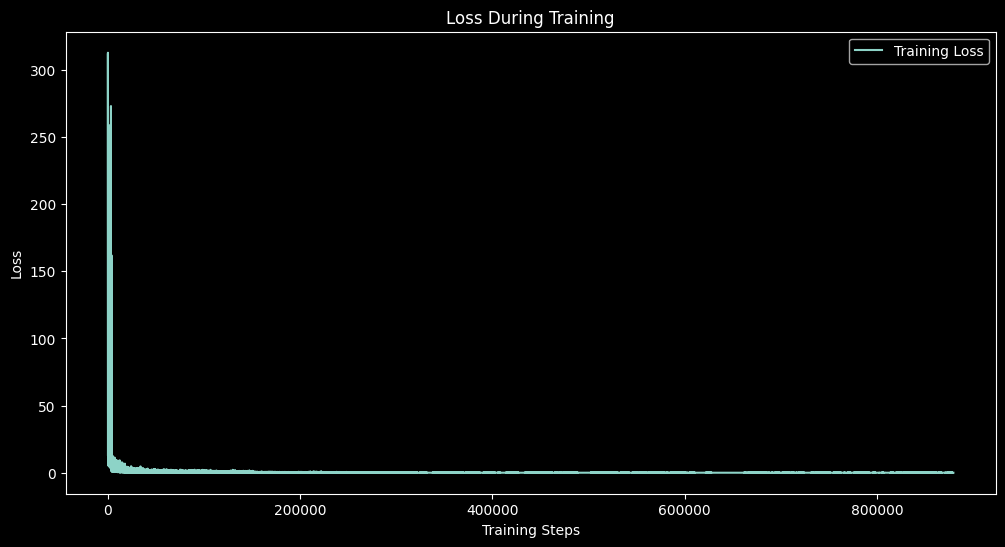

In [17]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import random
import torch.nn.functional as F
import gym

# Adjusting the training function to run for 2000 episodes
def train(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=5, reward_scaling=0.01):
    '''
    Train a DQN agent and record training statistics.
    '''
    # Initialize the scores list, scores window, and loss tracking
    scores = []
    losses = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    best_avg_score = -np.inf

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        total_loss = 0
        num_moves = 0

        # Loop over steps
        while True:
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Normalize reward
            reward = reward_scaling * reward

            # Update the agent and calculate loss
            loss = agent.step(state, action, reward, next_state, done)
            if loss is not None:
                total_loss += loss
                losses.append(loss)  # Track individual losses

            num_moves += 1
            state = next_state
            score += reward

            # End the episode if done
            if done:
                break

        # At the end of episode, append and save scores
        scores_window.append(score)
        scores.append(score)

        # Decrease epsilon for exploration-exploitation tradeoff
        eps = max(eps_end, eps_decay * eps)

        # Print detailed info for each episode
        avg_score = np.mean(scores_window)
        print(f"Episode {i_episode}, num. of moves: {num_moves}, cum. rewards: {score:.2f}, total loss: {total_loss:.2f}, avg score: {avg_score:.2f}")

        # Update target network every `target_update` episodes
        if i_episode % target_update == 0:
            agent.update_target_network()

        # Save the best model
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            torch.save(agent.q_network.state_dict(), 'best_model.pth')

        # Stop training if the environment is solved
        if i_episode % 100 == 0 and avg_score >= 200:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {avg_score:.2f}')
            break

    # Plot the loss curve after training
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()
    plt.show()

    return scores

# Example D3QN agent class with improved training techniques
class D3QNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=256, learning_rate=1e-4, gamma=0.99, buffer_size=50000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            return self.update_model()
        return None

    def act(self, state, eps=0.):
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Double DQN: get the next action from the online network and value from the target network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)

        # Compute the expected Q-values
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        loss = F.mse_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)  # Clip gradients to avoid exploding gradients
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Initialize environment and agent
env = gym.make('ALE/AirRaid-ram-v5')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = D3QNAgent(state_size, action_size)

# Train the agent with updated training code for 2000 episodes
scores = train(agent, env, n_episodes=2000)


Episode 1, num. of moves: 308, cum. rewards: 2.75, total loss: 14750.06, avg score: 2.75
Episode 2, num. of moves: 579, cum. rewards: 3.25, total loss: 21179.94, avg score: 3.00
Episode 3, num. of moves: 498, cum. rewards: 4.25, total loss: 17837.33, avg score: 3.42
Episode 4, num. of moves: 443, cum. rewards: 3.75, total loss: 11519.77, avg score: 3.50
Episode 5, num. of moves: 1146, cum. rewards: 16.25, total loss: 22632.13, avg score: 6.05
Episode 6, num. of moves: 436, cum. rewards: 3.50, total loss: 1253.88, avg score: 5.62
Episode 7, num. of moves: 1752, cum. rewards: 17.75, total loss: 3806.80, avg score: 7.36
Episode 8, num. of moves: 684, cum. rewards: 8.50, total loss: 1312.70, avg score: 7.50
Episode 9, num. of moves: 980, cum. rewards: 7.75, total loss: 1794.39, avg score: 7.53
Episode 10, num. of moves: 546, cum. rewards: 6.50, total loss: 955.75, avg score: 7.42
Episode 11, num. of moves: 1536, cum. rewards: 15.50, total loss: 1939.29, avg score: 8.16
Episode 12, num. of 

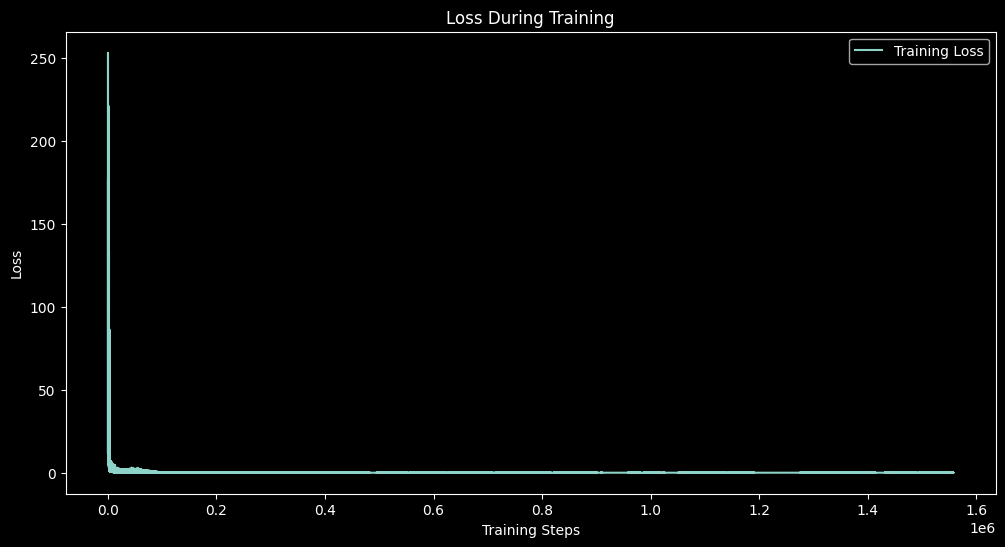

Episode 1: Reward = 975.00
Episode 2: Reward = 3200.00
Episode 3: Reward = 3350.00
Episode 4: Reward = 3725.00
Episode 5: Reward = 2300.00
Episode 6: Reward = 2425.00
Episode 7: Reward = 3675.00
Episode 8: Reward = 3450.00
Episode 9: Reward = 1950.00
Episode 10: Reward = 1950.00


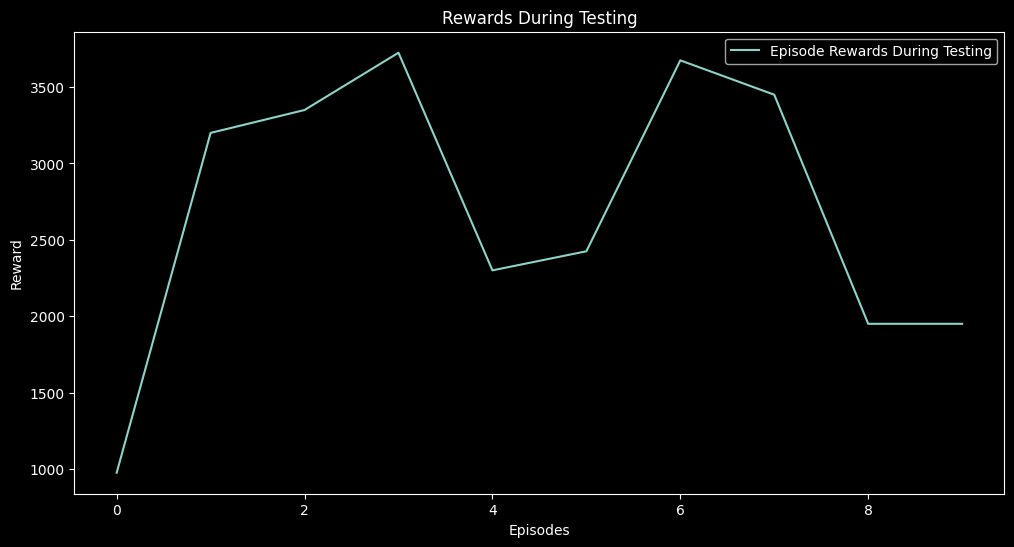

In [22]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import random
import torch.nn.functional as F
import gym

# Adjusting the training function to run for 2000 episodes
def train(agent, env, n_episodes=2500, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=5, reward_scaling=0.01):
    '''
    Train a DQN agent and record training statistics.
    '''
    # Initialize the scores list, scores window, and loss tracking
    scores = []
    losses = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    best_avg_score = -np.inf

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        total_loss = 0
        num_moves = 0

        # Loop over steps
        while True:
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Normalize reward
            reward = reward_scaling * reward

            # Update the agent and calculate loss
            loss = agent.step(state, action, reward, next_state, done)
            if loss is not None:
                total_loss += loss
                losses.append(loss)  # Track individual losses

            num_moves += 1
            state = next_state
            score += reward

            # End the episode if done
            if done:
                break

        # At the end of episode, append and save scores
        scores_window.append(score)
        scores.append(score)

        # Decrease epsilon for exploration-exploitation tradeoff
        eps = max(eps_end, eps_decay * eps)

        # Print detailed info for each episode
        avg_score = np.mean(scores_window)
        print(f"Episode {i_episode}, num. of moves: {num_moves}, cum. rewards: {score:.2f}, total loss: {total_loss:.2f}, avg score: {avg_score:.2f}")

        # Update target network every `target_update` episodes
        if i_episode % target_update == 0:
            agent.update_target_network()

        # Save the best model
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            torch.save(agent.q_network.state_dict(), 'best_model.pth')

        # Stop training if the environment is solved
        if i_episode % 100 == 0 and avg_score >= 200:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {avg_score:.2f}')
            break

    # Plot the loss curve after training
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()
    plt.show()

    return scores, losses

# Function to test the agent
def test(agent, env, n_episodes=10):
    agent.q_network.load_state_dict(torch.load('best_model.pth'))
    agent.q_network.eval()

    rewards = []
    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state, eps=0.0)  # Always take the best action during testing
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        print(f"Episode {i_episode}: Reward = {total_reward:.2f}")

    # Plotting the rewards obtained during testing
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Rewards During Testing')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Rewards During Testing')
    plt.legend()
    plt.show()

# Example D3QN agent class with improved training techniques
class D3QNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=256, learning_rate=1e-4, gamma=0.99, buffer_size=50000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            return self.update_model()
        return None

    def act(self, state, eps=0.):
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Double DQN: get the next action from the online network and value from the target network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)

        # Compute the expected Q-values
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        loss = F.mse_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)  # Clip gradients to avoid exploding gradients
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Initialize environment and agent
env = gym.make('ALE/AirRaid-ram-v5')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = D3QNAgent(state_size, action_size)

# Train the agent with updated training code for 2000 episodes
scores, losses = train(agent, env, n_episodes=2000)

# Test the agent with updated testing code and draw rewards during testing
test(agent, env, n_episodes=10)


![](https://ale.farama.org/_images/air_raid.gif)
(Dueling DQN)

We can also use the DDQN training trick to prevent the overestimation of Q-values from Dueling DQN. We can call this algorithm Dueling Double Deep Q-Network, or D3QN.

To use this, we just need to change the code in our DuelingDQN agent's `update_model` method so it uses the DDQN trick to prevent Q-value overestim


In [ ]:
class D3QNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  
            with torch.no_grad():
                action_values = self.q_network(state)

            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        '''
        Update the Q-network based on a batch of experiences from the replay memory.
        '''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get the action values from the online network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)

        # Get the Q-values from the target network for the actions chosen by the Q-network
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        '''
        Update the weights of the target network to match those of the Q-network.
        '''
        self.target_network.load_state_dict(self.q_network.state_dict())

# Make an environment
env = gym.make('ALE/AirRaid-ram-v5')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a D3QN agent
agent = D3QNAgent(state_size, action_size)

# Train it
scores = train(agent, env)

# Play a demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Episode 100	Average Score: 548.50
Score obtained: 1150.0


In [ ]:
import numpy as np
import random
import torch
import gym

class D3QNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            return self.update_model()
        return 0  # Return zero loss if not enough samples

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)
        
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

def play_episode(env, agent, episode_num, seed=42):
    state, _ = env.reset(seed=seed)
    done = False
    score = 0
    num_moves = 0
    total_loss = 0

    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        loss = agent.step(state, action, reward, next_state, done)
        total_loss += loss
        state = next_state
        score += reward
        num_moves += 1

    print(f"episode: {episode_num}, num. of moves: {num_moves}, cum. rewards: {score:.2f}, loss: {total_loss:.2f}")

# Make an environment
env = gym.make('ALE/AirRaid-ram-v5')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize a D3QN agent
agent = D3QNAgent(state_size, action_size)

# Run a few episodes for demonstration
for episode in range(50):  # Run 5 episodes as an example
    play_episode(env, agent, episode)



episode: 0, num. of moves: 2308, cum. rewards: 0.00, loss: 10517.98
episode: 1, num. of moves: 1946, cum. rewards: 0.00, loss: 5910.86
episode: 2, num. of moves: 2035, cum. rewards: 25.00, loss: 6408.86
episode: 3, num. of moves: 185, cum. rewards: 300.00, loss: 1019.42
episode: 4, num. of moves: 185, cum. rewards: 300.00, loss: 1450.38
episode: 5, num. of moves: 185, cum. rewards: 300.00, loss: 1714.52
episode: 6, num. of moves: 185, cum. rewards: 300.00, loss: 2271.13
episode: 7, num. of moves: 185, cum. rewards: 300.00, loss: 2894.73
episode: 8, num. of moves: 185, cum. rewards: 300.00, loss: 2867.10
episode: 9, num. of moves: 185, cum. rewards: 300.00, loss: 3200.85
episode: 10, num. of moves: 185, cum. rewards: 300.00, loss: 3340.38
episode: 11, num. of moves: 185, cum. rewards: 300.00, loss: 4570.54
episode: 12, num. of moves: 185, cum. rewards: 300.00, loss: 4821.19
episode: 13, num. of moves: 185, cum. rewards: 300.00, loss: 5221.12
episode: 14, num. of moves: 185, cum. rewards

In [ ]:

# env = gym.make(ENV_NAME, domain_randomize=True, render_mode='human') # <-- This would automatically open a pygame window (if pygame is available)

env = gym.wrappers.RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),    # instantiate env
    video_folder="../data/",                         # directory to save videos
    name_prefix="Assault",                       # root name of video files (e.g. expected filename = Assault-episode-0.mp4)
    episode_trigger=lambda x: x % 2 == 0,   # intervals at which to capture frames (e.g. every 2 moves)
    # disable_logger=True
)

state = env.reset()[0]  # reset environment for a new episode
done = False
total_reward = 0
moves = 0

env.start_video_recorder()  # <--- start recording
while not done:
    moves = moves + 1
    action = env.action_space.sample()  # Select a random action
    next_state, reward, truncated, terminated, _ = env.step(action) # Observe the next state for that action
    done = truncated or terminated      # test end of episode
    total_reward += reward              # cummulative score
    state = next_state

env.close_video_recorder() # <--- end recording

env.close()  # close the environment
print(f"Total Reward: {total_reward} in {moves} moves")

c:\Python37\lib\site-packages\gymnasium\utils\passive_env_checker.py:365: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."


Moviepy - Building video c:\Users\Rhash\OneDrive\data\Assault-episode-0.mp4.
Moviepy - Writing video c:\Users\Rhash\OneDrive\data\Assault-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Rhash\OneDrive\data\Assault-episode-0.mp4
Moviepy - Building video c:\Users\Rhash\OneDrive\data\Assault-episode-0.mp4.
Moviepy - Writing video c:\Users\Rhash\OneDrive\data\Assault-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Rhash\OneDrive\data\Assault-episode-0.mp4
Total Reward: 350.0 in 526 moves
